In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
ls

data/  drive/  model.pt  sample_data/


# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [ ]:
# Enter your information here
first_and_last_name = 'Sina Daneshgar'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [20]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [22]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    return (x - np.mean(x, axis=0)) / np.sqrt(np.var(x, axis=0) + epsilon) * gamma + beta


In [23]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [24]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])



# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data

indices = np.arange(len(train_set) // 2)
train_subset = Subset(train_set, indices)

train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=64, shuffle=False, num_workers=2)


# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Explain what we did in transform train and tranform test:<br/>
*answer* \\
i dont know how to answer this question, but i briefly explain the functions we used there! \\

RandomResizedCrop(224, scale=(0.5, 1.0)): \\
1. It randomly crops a region from the image, resizes it to 224x224 pixels.
2. Scale range (0.5, 1.0) ensures the crop size varies from 50% to 100% of the original image size. \\

RandomHorizontalFlip(): \\
Randomly flips the image horizontally with a probability of 0.5 \\

ToTensor(): \\
Converts the image to a PyTorch tensor with pixel values scaled to [0, 1]. The benefit of this function is we don't need to standardize our pixel afterwards. \\

Normalize(mean, std): \\
It normalizes the image using the given mean and standard deviation values for each channel. \\

The transform test functions is approximately similar to the train one, in summary we can say: \\

Training Transform: Includes data augmentation (random cropping and flipping) to enhance model generalization.

Test Transform: Resizes and normalizes images without augmentation to maintain consistency during evaluation.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

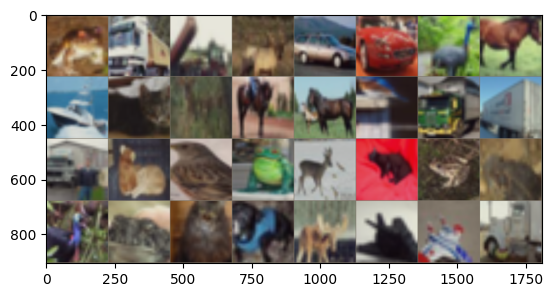

labels are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2])


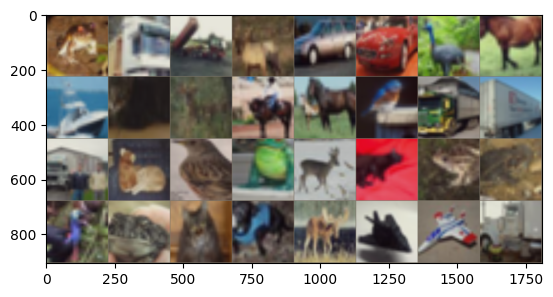

In [25]:
def imshow(img):
    # TODO:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()


# show some training images with shuffle=False and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
print(f'labels are: {labels[:128]}')

# show them again to check the augmentation
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

# create train loader with shuffle true
train_loader = DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=2)

For training our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [26]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    if train_mode:
      model.train()
    else:
      model.eval()

    epoch_losses = []
    running_loss = 0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if train_mode:
              loss.backward()
              optimizer.step()
            preds = torch.argmax(outputs, 1)

        epoch_losses += [loss.item()]
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    epoch_loss = running_loss / processed_data
    epoch_acc = running_corrects.cpu().numpy() / processed_data

    if train_mode:
      print("train_loss: {:0.4f} | train_acc: {:0.4f}".format(epoch_loss, epoch_acc))
    else:
      print("  val_loss: {:0.4f} |   val_acc: {:0.4f}".format(epoch_loss, epoch_acc))

    return epoch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    all_train_losses, all_val_losses = [], []
    best_val_loss = float('inf')
    MODEL_SAVE_PATH = './model.pt'

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        print('EPOCH #', epoch+1)
        train_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_losses   = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        all_train_losses += train_losses

        val_loss = np.array(val_losses).mean()
        all_val_losses += [val_loss]

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return all_train_losses, all_val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    running_corrects = 0
    processed_data = 0

    with torch.set_grad_enabled(False):
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)

    epoch_acc = running_corrects.cpu().numpy() / processed_data
    return epoch_acc



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    epochs = len(val_losses)
    train_losses_c = np.convolve(np.array(train_losses[:]),
                                np.ones(c_window)/c_window, mode='valid')

    plt.plot(train_losses_c, label='train_losses')
    plt.plot([i*len(train_losses)/epochs for i in range(1, epochs+1)], np.array(val_losses),
            label='val_losess', marker='o', markersize=8)
    plt.legend()
    plt.grid()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [27]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters (calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer** \\
It makes the model faster by splitting the convolution process into two separate operations, 1. depthwise convolution and 2. pointwise convolution \\

Normal Convolution parameter calculation:

Input channels:
𝑀

Output channels:
𝑁

Kernel size:
𝐾
×
𝐾

Number of parameters:

Parameters
=
𝑀
×
𝑁
×
𝐾^2 \\
 \\

Depthwise Separable Convolution parameter calculation:

Depthwise Convolution part:

Applies a single
𝐾
×
𝐾
 filter per input channel.
Parameters
depthwise
=
𝑀
×
𝐾^2 \\
 \\

Pointwise Convolution parameter calculation:

Applies a
1
×
1
 convolution to combine the output channels.

Parameters
pointwise
=
𝑀
×
𝑁 \\

Total Parameters: \\
Parameters
total
=
(𝑀
×
𝐾^2)
+
(𝑀
×
𝑁) \\
 \\
Effects on Speed Improvement:
Reduced Computation: Fewer parameters mean fewer multiplication and addition operators, leading to faster processing.

Efficiency: Depthwise separable convolutions require significantly less computation, making the model faster and more efficient, especially on resource-constrained devices like mobile phones.

Now please create your model.

In [28]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [29]:
model = MobileNet(n_class=100).to(device)

epochs = 10
lr = 1e-3

In [30]:
# TODO:

start_time = time.time()
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)
end_time = time.time()

print("Training time: {:.2f} seconds".format(end_time - start_time))

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 1.5028 | train_acc: 0.4567


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.2417 |   val_acc: 0.5644
EPOCH # 2


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 1.0662 | train_acc: 0.6218


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.9521 |   val_acc: 0.6695
EPOCH # 3


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.8465 | train_acc: 0.7048


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7459 |   val_acc: 0.7402
EPOCH # 4


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.7101 | train_acc: 0.7511


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6226 |   val_acc: 0.7869
EPOCH # 5


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.6285 | train_acc: 0.7836


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.6687 |   val_acc: 0.7715
EPOCH # 6


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.5610 | train_acc: 0.8050


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.5184 |   val_acc: 0.8213
EPOCH # 7


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.5182 | train_acc: 0.8212


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.4464 |   val_acc: 0.8483
EPOCH # 8


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.4768 | train_acc: 0.8339


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.4946 |   val_acc: 0.8310
EPOCH # 9


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.4421 | train_acc: 0.8479


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.4936 |   val_acc: 0.8351
EPOCH # 10


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.4068 | train_acc: 0.8600


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.4342 |   val_acc: 0.8559
Training time: 1995.66 seconds


Get some metrics and plot your losses.

  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8559
Process validation time: 18.9994 s


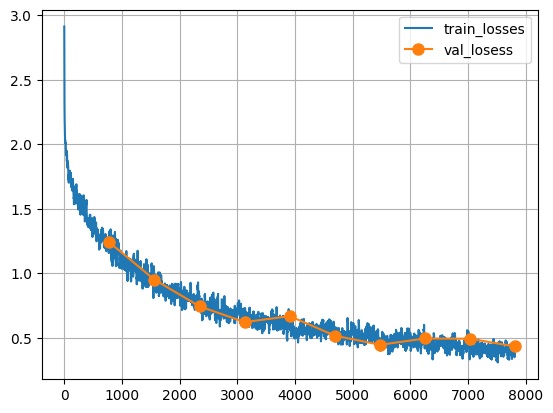

In [31]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.

**answer** \\
FLOPs Calculation: For a standard convolution layer, the number of FLOPs is calculated as the formula below: \\
FLOPs
=
2
×
input channels
×
output channels
×
kernel width
×
kernel height
×
input width
×
input height \\

Depthwise separable convolution: Applies a single filter per input channel, like the formula below: \\
FLOPs
depthwise
=
2
×
input channels
×
kernel width
×
kernel height
×
input width
×
input height \\

Pointwise Convolution: Combines the outputs of the depthwise convolution.

FLOPs
pointwise
=
2
×
input channels
×
output channels
×
input width
×
input height \\
and if we compare the formulas, the given result is: \\
Standard Convolution:
2
×
𝐶
in
×
𝐶
out
×
𝐾^2
×
𝐻
×
𝑊

Depthwise Separable Convolution:
(2
×
𝐶
in
×
𝐾^2
×
𝐻
×
𝑊)
+
(2
×
𝐶
in
×
𝐶
out
×
𝐻
×
𝑊) \\

Depthwise separable convolution significantly reduces the number of FLOPs compared to standard convolution, leading to the claim of 8 to 9 times faster computation.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [32]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [33]:
# TODO: train model
epochs = 2
lr = 1e-3
model = NormalCNN(n_class=100).to(device)

train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 1.8120 | train_acc: 0.3274


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.5253 |   val_acc: 0.4385
EPOCH # 2


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 1.3524 | train_acc: 0.5091


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.1667 |   val_acc: 0.5856


  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.5856
Process validation time: 20.7166 s


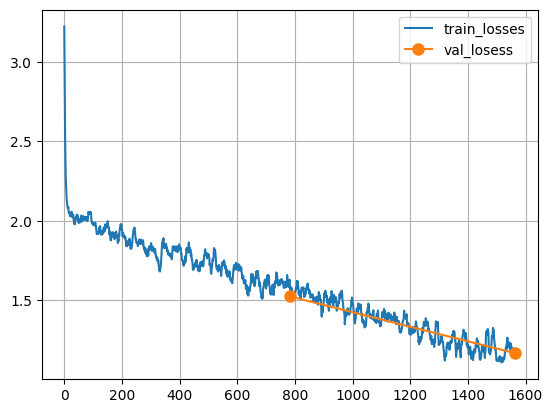

In [34]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer** \\
 \\


*   **Normal CNN**

Learning speed is slower due to more parameters and computations.

Validation Speed is also slower because of the higher computational load.

* **MobileNet**

Learning Speed is faster due to fewer parameters and efficient **depthwise separable convolutions**.

Validation Speed is much quicker, benefiting from reduced complexity and optimized operations.


In [35]:
# TODO: compare number of parameters in these two models

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Normal CNN
print(f'Total number of normal CNN parameters: {count_parameters(model)}')

# MobileNet
print(f'Total number of MobileNet parameters: {count_parameters(MobileNet(n_class=100))}')

Total number of normal CNN parameters: 28371588
Total number of MobileNet parameters: 3309476


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [36]:
model = MobileNet(n_class=100).to(device)

# Load the pre-trained weights
pretrained_dict = torch.load('model.pt')

# Filter out unnecessary keys (fc layer)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}

# Modify the keys to match the new model's expected key format
modified_dict = {}
for k, v in pretrained_dict.items():

    modified_key = k.replace('.', '.0.')
    modified_dict[modified_key] = v

# Load the modified state dict into the model
model.load_state_dict(modified_dict, strict=False)

<ipython-input-36-021890ac5276>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('model.pt')


_IncompatibleKeys(missing_keys=['model.0.0.weight', 'model.0.1.weight', 'model.0.1.bias', 'model.0.1.running_mean', 'model.0.1.running_var', 'model.1.0.weight', 'model.1.1.weight', 'model.1.1.bias', 'model.1.1.running_mean', 'model.1.1.running_var', 'model.1.3.weight', 'model.1.4.weight', 'model.1.4.bias', 'model.1.4.running_mean', 'model.1.4.running_var', 'model.2.0.weight', 'model.2.1.weight', 'model.2.1.bias', 'model.2.1.running_mean', 'model.2.1.running_var', 'model.2.3.weight', 'model.2.4.weight', 'model.2.4.bias', 'model.2.4.running_mean', 'model.2.4.running_var', 'model.3.0.weight', 'model.3.1.weight', 'model.3.1.bias', 'model.3.1.running_mean', 'model.3.1.running_var', 'model.3.3.weight', 'model.3.4.weight', 'model.3.4.bias', 'model.3.4.running_mean', 'model.3.4.running_var', 'model.4.0.weight', 'model.4.1.weight', 'model.4.1.bias', 'model.4.1.running_mean', 'model.4.1.running_var', 'model.4.3.weight', 'model.4.4.weight', 'model.4.4.bias', 'model.4.4.running_mean', 'model.4.4.r

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [37]:
# Freeze up to the desired layer (e.g., the first 7 layers)

# for i, child in enumerate(model.model.children()):
#     if i < 7:
#         for param in child.parameters():
#             param.requires_grad = False

layer_counter = 0
for layer in model.model.children():
    layer_counter += 1
    if layer_counter <= 5:  # Freeze up to layer 5
        for param in layer.parameters():
            param.requires_grad = False
    else:  # Unfreeze the rest
        for param in layer.parameters():
            param.requires_grad = True


for i, (name, param) in enumerate(model.named_parameters()):
    print(f"Layer {i + 1}: {name} | requires_grad: {param.requires_grad}")

Layer 1: model.0.0.weight | requires_grad: False
Layer 2: model.0.1.weight | requires_grad: False
Layer 3: model.0.1.bias | requires_grad: False
Layer 4: model.1.0.weight | requires_grad: False
Layer 5: model.1.1.weight | requires_grad: False
Layer 6: model.1.1.bias | requires_grad: False
Layer 7: model.1.3.weight | requires_grad: False
Layer 8: model.1.4.weight | requires_grad: False
Layer 9: model.1.4.bias | requires_grad: False
Layer 10: model.2.0.weight | requires_grad: False
Layer 11: model.2.1.weight | requires_grad: False
Layer 12: model.2.1.bias | requires_grad: False
Layer 13: model.2.3.weight | requires_grad: False
Layer 14: model.2.4.weight | requires_grad: False
Layer 15: model.2.4.bias | requires_grad: False
Layer 16: model.3.0.weight | requires_grad: False
Layer 17: model.3.1.weight | requires_grad: False
Layer 18: model.3.1.bias | requires_grad: False
Layer 19: model.3.3.weight | requires_grad: False
Layer 20: model.3.4.weight | requires_grad: False
Layer 21: model.3.4.b

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [38]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:05<00:00, 29.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

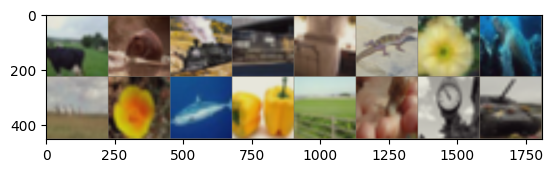

labels are:  tensor([19,  4, 90, 90,  5, 44, 92, 93, 60, 62, 73, 83, 60, 77, 22, 85])


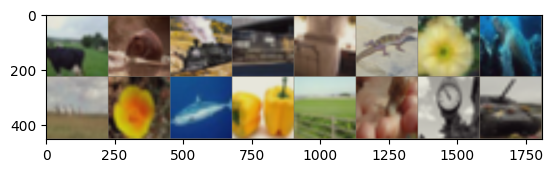

In [39]:
# show some training images with shuffle=False and labels
dataiter = iter(train_loader100)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print('labels are: ', labels[:16])

# show them again to check the augmentation
dataiter = iter(train_loader100)
imshow(torchvision.utils.make_grid(images[:16]))

Do CIFAR10 and CIFAR100 use the same images but with diffrent labels? (maybe you should search)

**answer** \\
Yes, CIFAR-10 and CIFAR-100 use the same set of 60,000 images. The difference lies in their labels. \\
CIFAR-10: (10 Classes) - (Broader categories like "cat", "dog")
(Labels are Generalized and simpler) \\
CIFAR-100: (100 Classes) (More specific categories like "Persian cat", "Boeing 737")
(Labels are Detailed and fine-grained)

Then we conclude that both datasets share the same images, but CIFAR-100 provides more detailed labeling, making it a more challenging dataset.

Now train your model using your functions.

In [40]:
epochs = 7
lr = 2e-4

In [41]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


model.0.0.weight: requires_grad=False
model.0.1.weight: requires_grad=False
model.0.1.bias: requires_grad=False
model.1.0.weight: requires_grad=False
model.1.1.weight: requires_grad=False
model.1.1.bias: requires_grad=False
model.1.3.weight: requires_grad=False
model.1.4.weight: requires_grad=False
model.1.4.bias: requires_grad=False
model.2.0.weight: requires_grad=False
model.2.1.weight: requires_grad=False
model.2.1.bias: requires_grad=False
model.2.3.weight: requires_grad=False
model.2.4.weight: requires_grad=False
model.2.4.bias: requires_grad=False
model.3.0.weight: requires_grad=False
model.3.1.weight: requires_grad=False
model.3.1.bias: requires_grad=False
model.3.3.weight: requires_grad=False
model.3.4.weight: requires_grad=False
model.3.4.bias: requires_grad=False
model.4.0.weight: requires_grad=False
model.4.1.weight: requires_grad=False
model.4.1.bias: requires_grad=False
model.4.3.weight: requires_grad=False
model.4.4.weight: requires_grad=False
model.4.4.bias: requires_gra

In [42]:
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

  0%|          | 0/7 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 4.3450 | train_acc: 0.0439


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 4.0891 |   val_acc: 0.0708
EPOCH # 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.9115 | train_acc: 0.0953


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.9912 |   val_acc: 0.0779
EPOCH # 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.6695 | train_acc: 0.1314


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.5995 |   val_acc: 0.1424
EPOCH # 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.4891 | train_acc: 0.1683


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.5580 |   val_acc: 0.1579
EPOCH # 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.3218 | train_acc: 0.1971


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.4661 |   val_acc: 0.1746
EPOCH # 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.1903 | train_acc: 0.2190


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.2263 |   val_acc: 0.2148
EPOCH # 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.0582 | train_acc: 0.2435


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.1588 |   val_acc: 0.2267


Get some metrics and plot your losses.

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.2267
Process validation time: 18.5073 s


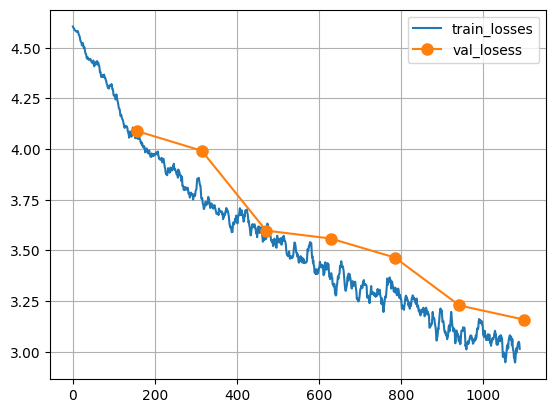

In [43]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer** \\
ReLU6 is a variant of the ReLU activation function. It clips the output at 6, which is defined as:

ReLU6(𝑥) = min⁡(max⁡(0,𝑥), 6) \\

Why we use ReLU6? \\
1. Prevention of Numeric Overflow: Limits the activation values to the range [0, 6], preventing the potential for numerical instability, especially in quantized neural networks. \\
2. Improved Performance in Quantized Networks: Works well with lower precision representations, like 8-bit integers, which are common in mobile and embedded systems. \\
3. Keeps the activations within a bounded range, which can help in scenarios where large activations might degrade the performance of the subsequent layers.

In [44]:
def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU6(inplace=True)
            )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU6(inplace=True)
            )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size
        super(InvertedResidual, self).__init__()

        self.use_res_connect = (stride == 1) and (inp == oup)
        hidden_dim = int(inp * expand_ratio)

        # Determine if a skip connection should be used


        # (only used when stride is 1 and input channels == output channels)


        # Calculate the number of hidden channels after expansion


        # If expand_ratio is 1, skip the initial pointwise convolution
        if expand_ratio == 1:
                self.conv = nn.Sequential(
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

        else:
                self.conv = nn.Sequential(
                # Pointwise convolution to increase channel depth
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution to reduce channel depth
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        # Forward pass with optional residual connection
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [45]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()

        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]
        input_channel = 32
        last_channel = 1280
        self.width_multiplier = width_multiplier

        # building first layer
        input_channels = input_channels = int(32 * width_multiplier)
        self.features = [conv_bn(3, input_channels, 2)]

        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channels = int(c * width_multiplier)
            for i in range(n):
                if i == 0:
                    self.features.append(InvertedResidual(input_channels, output_channels, s, expand_ratio=t))
                else:
                    self.features.append(InvertedResidual(input_channels, output_channels, 1, expand_ratio=t))
                input_channels = output_channels

        # building last several layers
        self.features.append(conv_1x1_bn(input_channels, int(1280 * width_multiplier)))
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(int(1280 * width_multiplier), n_class)

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


**answer** \\
In the MobileNetV2 architecture, linear bottlenecks are implemented through the InvertedResidual blocks. \\
The roadmap is: Expand channels -> Depthwise Convolution -> Reduce channels \\
Their benefit is to reduce parameters and dimensonality reduction, keep the model lightweight while maintaining, and minimizing information loss during this reduction. \\
In the end, it enhances efficiency and performance balance, which is ideal for mobile applications.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [46]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3

train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 1.4715 | train_acc: 0.4637


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.3164 |   val_acc: 0.5380
EPOCH # 2


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 1.0483 | train_acc: 0.6272


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.9346 |   val_acc: 0.6813
EPOCH # 3


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.8580 | train_acc: 0.6975


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7776 |   val_acc: 0.7294
EPOCH # 4


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.7449 | train_acc: 0.7383


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7213 |   val_acc: 0.7519
EPOCH # 5


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.6745 | train_acc: 0.7657


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.7294 |   val_acc: 0.7574
EPOCH # 6


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.6232 | train_acc: 0.7833


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.5920 |   val_acc: 0.7993
EPOCH # 7


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.5855 | train_acc: 0.7965


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.5738 |   val_acc: 0.8026
EPOCH # 8


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.5478 | train_acc: 0.8088


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.5098 |   val_acc: 0.8241
EPOCH # 9


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.5196 | train_acc: 0.8197


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.4731 |   val_acc: 0.8374
EPOCH # 10


  0%|          | 0/782 [00:00<?, ?it/s]

train_loss: 0.4913 | train_acc: 0.8302


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.4771 |   val_acc: 0.8408


Get some metrics and plot your losses.

  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8408
Process validation time: 19.5482 s


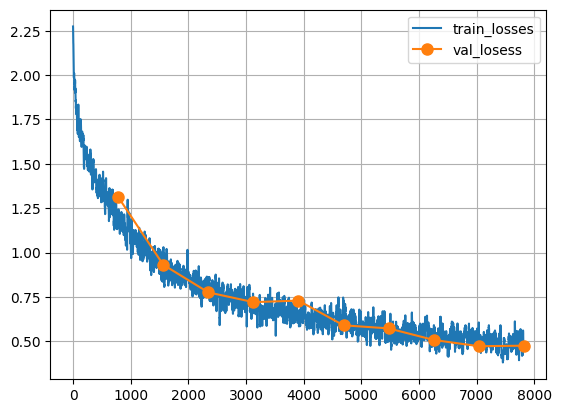

In [47]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [50]:
# TODO
for width_multiplier in [x * 0.1 for x in range(1, 11)]:
    model = MobileNetV2(n_class=10, width_multiplier=width_multiplier)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"with {width_multiplier:.1f} width multiplier we got {num_params:} parameters")

with 0.1 width multiplier we got 31255 parameters
with 0.2 width multiplier we got 105224 parameters
with 0.3 width multiplier we got 221676 parameters
with 0.4 width multiplier we got 380438 parameters
with 0.5 width multiplier we got 587178 parameters
with 0.6 width multiplier we got 826943 parameters
with 0.7 width multiplier we got 1113168 parameters
with 0.8 width multiplier we got 1441788 parameters
with 0.9 width multiplier we got 1812806 parameters
with 1.0 width multiplier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [51]:
MNv2_path = './MNv2WMmodel.pt'
# TODO
model_MNv2 = MobileNetV2(n_class=10, width_multiplier=0.5)
model_MNv2.load_state_dict(torch.load(MNv2_path, weights_only=True))
model_MNv2.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(8, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3

In [53]:
start = time.time()
val_acc = get_acc(model_MNv2, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

  0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.7432
Process validation time: 20.5630 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer** \\

For a given layer with input channel (m) and output channel (n), while we assume width_multiplier (alpha), we can formulate the prediction like: \\
input channels: alpha * m \\
output channels: alpha * n \\
and then we can conclude that: \\
total number of parameters = alpha^2 * (m * n) \\
for example, alpha = 1, doesn't make any changes in number of parameters. alpha = 0.25, reduce parameters by a factor of 16 {(1/4)^2} \\

Trade-offs:
Higher alpha: Larger model -> more parameters, potentially better performance but higher computational cost.

Lower alpha: Smaller model -> fewer parameters, lower computational cost but might sacrifice some accuracy.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer** \\
The resolution multiplier adjusts the input image size to the model. For example, reducing the resolution of input images from 224x224 to 112x112. \\
 \\
Impact on **Model Speed**: \\
Faster Processing: Yes, using a lower resolution multiplier makes the model faster. Smaller input images require fewer computations in each convolutional layer.

Reduced Computational Load: Less data to process means quicker forward and backward passes during training and inference. \\
 \\
 Impact on **Number of Parameters**: \\
Parameters Unaffected: The resolution multiplier does not directly decrease the number of parameters. The parameters in convolutional layers depend on the kernel sizes, number of channels, and the number of layers, not the input resolution.

Indirect Effects: While the number of parameters remains the same, the effective workload per parameter decreases due to smaller input sizes, leading to efficiency gains. \\

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer** \\
1. Overfitting Risk: Models with too many parameters might overfit to the training data, learning noise instead of the actual patterns. This can lead to poor performance on unseen data. \\
2. Resource Efficiency: \\
Memory Usage: More parameters the model has, more memory we need. Even with powerful GPUs, there are limits to how much memory can be utilized effectively. \\
Training Time: More parameters mean longer training times, which can increase costs and delay model deployment. \\
3. Inference Speed: \\
Larger models can be slower to make predictions, which is critical in real-time applications like autonomous driving or live video analysis. \\
4. Energy Consumption: \\
More parameters lead to higher energy consumption. With growing concerns about the environmental impact of large-scale AI models, efficiency matters.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [54]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [55]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

  0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.0974
Process validation time: 20.2628 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [56]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)

        student_log_probs = F.log_softmax(student_logits / self.temperature, dim=1)

        distillation_loss = self.kl_div(student_log_probs, teacher_probs) * (self.temperature ** 2)

        classification_loss = F.cross_entropy(student_logits, labels)

        loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher(images)
            student_logits = student(images)

            loss = criterion(student_logits, teacher_logits, labels)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")


Train it for one epoch to just check if it works.

In [57]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/1, Loss: 0.9512


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer** \\
**High alpha (like 0.9)** \\
Focus: Strong emphasis on matching the ground truth labels. \\
Risk: Overfitting potential, but ensures the model aligns **well** with specific target tasks. \\
Benefit: Might excel in scenarios where detailed task performance is crucial. \\

**Low alpha (like 0.1)** \\
Focus: More focus on learning from teacher's knowledge. \\
Risk: Underfitting potential, but might better capture general patterns from teacher. \\
Benefit: generalize better across diverse datasets. \\

**Tradeoff impact**: \\
High Alpha: Better precision on specific tasks but risks overfitting.

Low Alpha: Better for generalization across varied data but risks not aligning perfectly with target tasks.

A balanced alpha value (like 0.5) can offer a mix of both benefits, leveraging both the ground truth and the teacher's expertise. This helps in achieving a good balance between task-specific performance and generalization.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## References

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018